# Employee Sentiment Analysis Project
# Author: Varsana Ilango
# Date: 6/17/25
# Description: This notebook analyzes employee messages to determine sentiment, engagement, 
# calculate scores, identify flight risks, and build predictive models to understand trends.

# ----------------------------------------------------------
# Objective:
# - Label employee messages with sentiment (Positive, Negative, Neutral)
# - Perform Exploratory Data Analysis (EDA)
# - Calculate monthly sentiment scores for each employee
# - Generate employee rankings
# - Identify employees at risk of leaving ("Flight Risk")
# - Build predictive models to forecast sentiment trends

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [17]:
# Define file path for dataset
file_path = '/employee_sentiment_analysis/data/test(in).csv'

# Load dataset
df = pd.read_csv(file_path)

# Display dataset information
print("Dataset shape:", df.shape)
df.head()

# Display data types and check for missing values
df.info()
df.isnull().sum()

Dataset shape: (2191, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB


Subject    0
body       0
date       0
from       0
dtype: int64

Sentiment
Positive    1144
Neutral      817
Negative     230
Name: count, dtype: int64


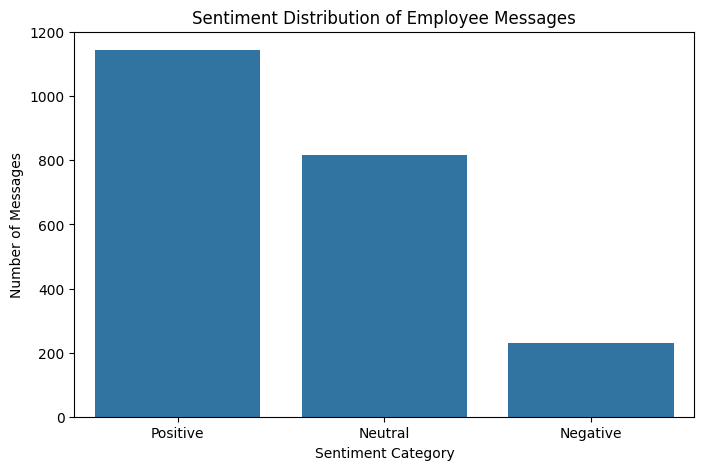

In [32]:
# Sentiment Labeling (Task 1)

# Objective: Automatically label each employee message as Positive, Negative, or Neutral

# Function to calculate sentiment label based on TextBlob polarity
def get_sentiment_label(text):
    blob = TextBlob(str(text))
    polarity = blob.sentiment.polarity
    if polarity > 0.05:
        return 'Positive'
    elif polarity < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment labeling to the 'body' column
df['Sentiment'] = df['body'].apply(get_sentiment_label)


df[['Subject', 'body', 'Sentiment']].head()


# Count the occurrences of each sentiment label
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)

# Visualize the sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title("Sentiment Distribution of Employee Messages")
plt.ylabel("Number of Messages")
plt.xlabel("Sentiment Category")

plt.savefig('/employee_sentiment_analysis/visualization/sentiment_distribution.png', dpi=300, bbox_inches='tight')

plt.show()


# Observation:
# Most messages fall into positive, with few being negative. 

#Additional Notes
# TextBlob was selected for sentiment labeling since it has a built-in sentiment polarity scoring.


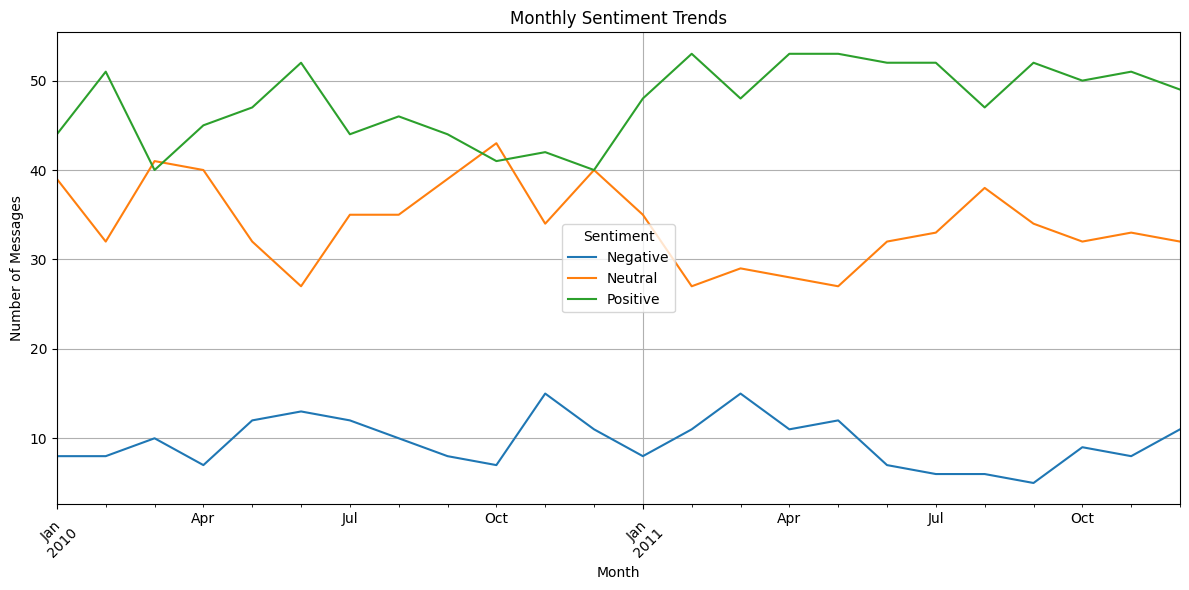

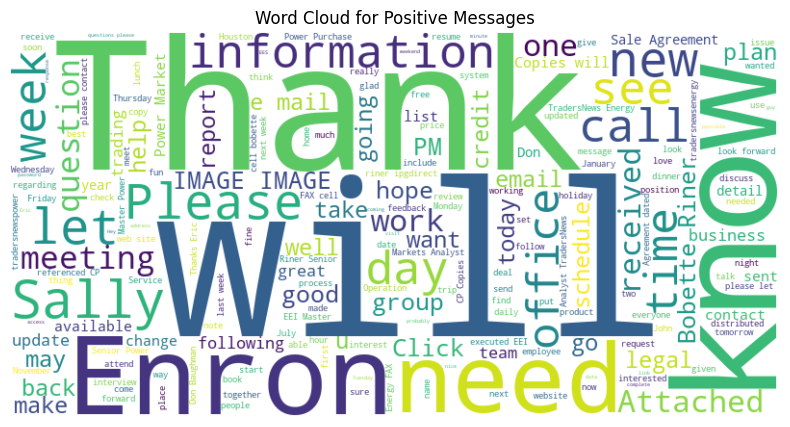

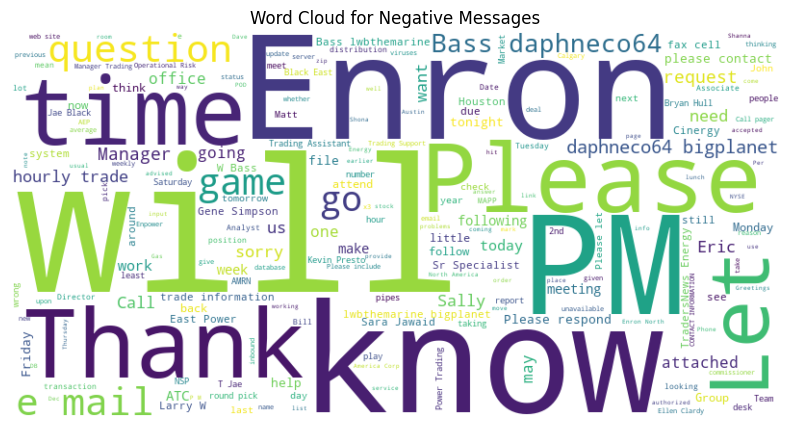

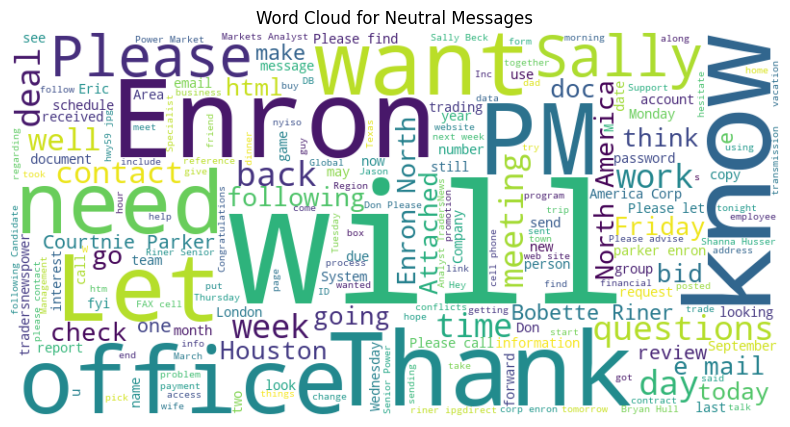

In [35]:

# Exploratory Data Analysis (EDA) (Task 2)

# Objective: Understand the structure, distribution, and trends in the dataset through exploration

# Summary statistics of the dataset
df.describe(include='all')

# Count of missing values per column
df.isnull().sum()


# Distribution of Sentiments Over Time

# Convert 'date' column to datetime format for analysis
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with invalid or missing dates 
df = df.dropna(subset=['date'])

# Group by date and sentiment
sentiment_over_time = df.groupby([df['date'].dt.to_period('M'), 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiment trend over time
sentiment_over_time.plot(kind='line', figsize=(12, 6))
plt.title("Monthly Sentiment Trends")
plt.ylabel("Number of Messages")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('/employee_sentiment_analysis/visualization/monthly_sentiment_trends.png', dpi=300, bbox_inches='tight')
plt.show()


# Word Clouds for Each Sentiment

# Generate and display a word cloud for each sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    text = " ".join(df[df['Sentiment'] == sentiment]['body'].astype(str).values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {sentiment} Messages")
    filename = f'/employee_sentiment_analysis/visualization/wordcloud_{sentiment.lower()}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


# Observation:
# Sentiment trends fluctuate over months due to events or mood changes. 
# Word clouds reveal frequently used words associated with each sentiment category.

In [36]:

# Employee Score Calculation (Task 3)

# Objective: Compute a monthly sentiment score for each employee based on their messages

# Function to map sentiment to numerical scores
def sentiment_to_score(sentiment):
    if sentiment == 'Positive':
        return 1
    elif sentiment == 'Negative':
        return -1
    else:
        return 0

# Apply sentiment scores
df['Sentiment_Score'] = df['Sentiment'].apply(sentiment_to_score)

# Extract year and month for grouping
df['YearMonth'] = df['date'].dt.to_period('M')

# Group by employee and month to sum up the sentiment scores
monthly_scores = df.groupby(['from', 'YearMonth'])['Sentiment_Score'].sum().reset_index()

monthly_scores.to_csv('/employee_sentiment_analysis/visualization/monthly_sentiment_scores.csv', index=False)

# Observation:
# Each employee has a monthly sentiment score summarizing their message sentiment.


In [37]:
# Employee Ranking (Task 4)

# Objective: Generate ranked lists of employees based on their monthly sentiment scores.

# Sort by YearMonth and Sentiment_Score for ranking (Positive ranking)
ranked_positive = monthly_scores.sort_values(by=['YearMonth', 'Sentiment_Score', 'from'], ascending=[True, False, True])

# Sort by YearMonth and Sentiment_Score for ranking (Negative ranking)
ranked_negative = monthly_scores.sort_values(by=['YearMonth', 'Sentiment_Score', 'from'], ascending=[True, True, True])

# Function to extract top 3 positive and negative employees per month
def get_top_n_employees(df, n=3):
    return df.groupby('YearMonth').head(n)

# Top 3 positive and negative employees per month
top_positive = get_top_n_employees(ranked_positive, n=3)
top_negative = get_top_n_employees(ranked_negative, n=3)

print("Top 3 Positive Employees Per Month:")
print(top_positive)

print("Top 3 Negative Employees Per Month:")
print(top_negative)


top_positive.to_csv('/employee_sentiment_analysis/visualization/top_positive_employees.csv', index=False)
top_negative.to_csv('/employee_sentiment_analysis/visualization/top_negative_employees.csv', index=False)

# Observation:
# One list for the top three positive employees and one list for the top three negative employees for each month.

Top 3 Positive Employees Per Month:
                            from YearMonth  Sentiment_Score
120      kayne.coulter@enron.com   2010-01                8
24        don.baughman@enron.com   2010-01                5
48           eric.bass@enron.com   2010-01                5
1    bobette.riner@ipgdirect.com   2010-02                8
73         john.arnold@enron.com   2010-02                8
..                           ...       ...              ...
142      kayne.coulter@enron.com   2011-11                8
22   bobette.riner@ipgdirect.com   2011-11                7
167      lydia.delgado@enron.com   2011-12                6
191     patti.thompson@enron.com   2011-12                6
143      kayne.coulter@enron.com   2011-12                5

[72 rows x 3 columns]
Top 3 Negative Employees Per Month:
                            from YearMonth  Sentiment_Score
192      rhonda.denton@enron.com   2010-01                0
96       johnny.palmer@enron.com   2010-01                1
0    

In [41]:

# Flight Risk Identification (Task 5)

# Objective:
# Identify employees who have sent 4 or more negative messages within any rolling 30-day window.

# 'date' column is datetime and sorted
df = df.sort_values(by=['from', 'date'])

# Filter negative messages 
negatives = df[df['Sentiment'] == 'Negative'][['from', 'date']]

# Initialize a list to store flight risk flags
flight_risk_employees = []

# analyze rolling 30-day windows per employee 
for employee, group in negatives.groupby('from'):
    
    dates = group['date'].sort_values()
    
    # Use pandas rolling count approach with expanding window 
    
    date_list = dates.values
    start_idx = 0
    at_risk = False
    for end_idx in range(len(date_list)):
        # Move start_idx forward while window > 30 days
        while (date_list[end_idx] - date_list[start_idx]).astype('timedelta64[D]').astype(int) > 30:
            start_idx += 1
        window_count = end_idx - start_idx + 1
        if window_count >= 4:
            at_risk = True
            break
    
    if at_risk:
        flight_risk_employees.append(employee)


print(f"Number of employees at flight risk: {len(flight_risk_employees)}")
print("Employees at flight risk:")
print(flight_risk_employees)

pd.DataFrame(flight_risk_employees, columns=['Employee']).to_csv('/employee_sentiment_analysis/visualization/flight_risk_employees.csv', index=False)

# Observation:

# Employees with frequent negative messages within a 30-day period may be dissatisfied, which indicates a potential flight risk.


Number of employees at flight risk: 8
Employees at flight risk:
['bobette.riner@ipgdirect.com', 'eric.bass@enron.com', 'john.arnold@enron.com', 'johnny.palmer@enron.com', 'lydia.delgado@enron.com', 'patti.thompson@enron.com', 'rhonda.denton@enron.com', 'sally.beck@enron.com']


Predicted sentiment score for next month for employee bobette.riner@ipgdirect.com: 3.87
Actual sentiment score: 1
Training MAE: 2.643, RMSE: 3.148, R^2: 0.000


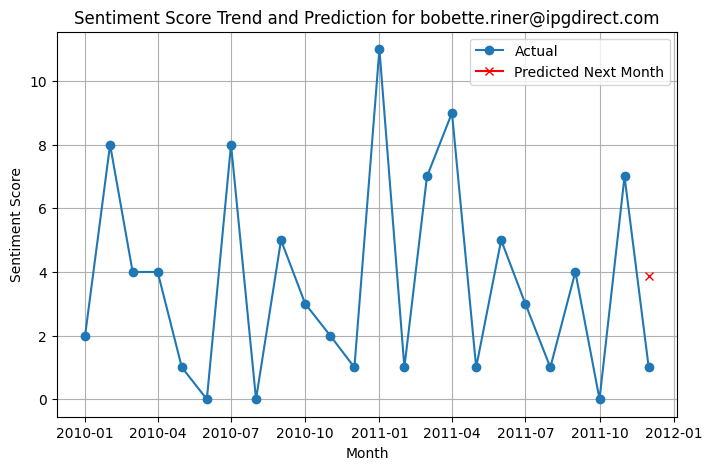

Plot saved as: /Users/varsana/employee_sentiment_analysis/visualization/prediction_trend_bobette_riner_at_ipgdirect_com.png


In [42]:
# Predictive Modeling of Sentiment Trends (Task 6)

# Objective:
# Build a model to predict future sentiment scores for employees based on past data.

# Sort data
monthly_scores = monthly_scores.sort_values(by=['from', 'YearMonth'])

# Convert YearMonth to numeric timestamp for modeling
monthly_scores['YearMonth_num'] = monthly_scores['YearMonth'].apply(lambda x: x.to_timestamp()).astype(np.int64) // 10**9  # convert to UNIX timestamp seconds

# Predict next month's sentiment score for a sample employee
sample_employee = monthly_scores['from'].iloc[0]  # first employee in data

emp_data = monthly_scores[monthly_scores['from'] == sample_employee]

# Prepare features and target
X = emp_data[['YearMonth_num']]
y = emp_data['Sentiment_Score']

# Train-test split
if len(emp_data) > 1:
    X_train, X_test = X.iloc[:-1], X.iloc[-1:]
    y_train, y_test = y.iloc[:-1], y.iloc[-1:]
else:
    print(f"Not enough data to train model for employee {sample_employee}.")
    X_train, X_test, y_train, y_test = None, None, None, None

# Fit linear regression model
if X_train is not None:
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    print(f"Predicted sentiment score for next month for employee {sample_employee}: {y_pred[0]:.2f}")
    print(f"Actual sentiment score: {y_test.values[0]}")

    # Model evaluation on training data
    y_train_pred = model.predict(X_train)
    mae = mean_absolute_error(y_train, y_train_pred)
    rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2 = r2_score(y_train, y_train_pred)

    print(f"Training MAE: {mae:.3f}, RMSE: {rmse:.3f}, R^2: {r2:.3f}")

    # Plot trend and prediction
    plt.figure(figsize=(8,5))
    plt.plot(emp_data['YearMonth'].dt.to_timestamp(), y, marker='o', label='Actual')
    plt.plot(X_test['YearMonth_num'].apply(pd.to_datetime, unit='s'), y_pred, marker='x', color='red', label='Predicted Next Month')
    plt.title(f'Sentiment Score Trend and Prediction for {sample_employee}')
    plt.xlabel('Month')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.grid(True)
   

    file_name = f"/employee_sentiment_analysis/visualization/prediction_trend_{sample_employee.replace('@','_at_').replace('.','_')}.png"
    plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plot saved as: {file_name}")
    
